In [4]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

Read in CSV files to Pandas dataframes

In [173]:
greenroof_df = pd.read_csv("Data/Green_Roof_data.csv")
airquality_df = pd.read_csv("Data/Air_Quality.csv")

# Green Roof dataframe

In [174]:
greenroof_df.head()

,fid,bin,bbl,gr_area,bldg_area,prop_gr,cnstrct_yr,doitt_id,heightroof,feat_code,...,newlyadded,original_source,address,borough,ownertype,zonedist1,spdist1,bbl_fixed,xcoord,ycoord
0,1,3393257.0,3013530001,971.97562,14057.66054,0.06914,1921.0,485656.0,59.24000,2100.0,...,0,DPR,119 TROY AVENUE,BK,C,PARK,NaN,0,-73.93491,40.67389
1,2,1010518.0,1006060004,696.97393,4463.34665,0.15616,1920.0,63711.0,13.69000,2100.0,...,0,classification,18 GREENWICH AVENUE,MN,NaN,C1-6,NaN,0,-73.99982,40.73481
2,3,1010288.0,1005947501,293.99617,13217.61133,0.02224,1909.0,84851.0,93.78000,2100.0,...,0,classification,479 GREENWICH STREET,MN,NaN,C6-2A,NaN,0,-74.00906,40.72480
3,4,1001596.0,1001467503,759.21592,4311.07761,0.17611,1920.0,821215.0,99.98000,2100.0,...,0,classification,104 READE STREET,MN,NaN,C6-2A,TMU,0,-74.00836,40.71595
4,5,2117344.0,2023597501,7204.18379,35891.53358,0.20072,2010.0,1257143.0,206.20024,2100.0,...,0,greenroofs.com,700-704 BROOK AVENUE,BX,NaN,C6-2,NaN,0,-73.91227,40.81906


There are 736 buidling in this dataset. I examined possible columns that we could use as a unique key for each building if we need. Based on this, it's clear that the 'fid' and 'doitt_id' have a unique value for each building

In [175]:
greenroof_df.shape
ids = ['fid', 'bin', 'bbl', 'doitt_id']
for i in ids:
    print(i + ": " + str(len(pd.unique(greenroof_df[i]))))

fid: 736
bin: 735
bbl: 704
doitt_id: 736


### Columns

In [176]:
greenroof_df.columns

Index(['fid', 'bin', 'bbl', 'gr_area', 'bldg_area', 'prop_gr', 'cnstrct_yr',
       'doitt_id', 'heightroof', 'feat_code', 'groundelev', 'qa', 'notes',
       'classified', 'digitized', 'newlyadded', 'original_source', 'address',
       'borough', 'ownertype', 'zonedist1', 'spdist1', 'bbl_fixed', 'xcoord',
       'ycoord'],
      dtype='object')

In [177]:
greenroof_df.dtypes

fid                  int64
bin                float64
bbl                  int64
gr_area            float64
bldg_area          float64
prop_gr            float64
cnstrct_yr         float64
doitt_id           float64
heightroof         float64
feat_code          float64
groundelev         float64
qa                  object
notes               object
classified           int64
digitized            int64
newlyadded           int64
original_source     object
address             object
borough             object
ownertype           object
zonedist1           object
spdist1             object
bbl_fixed            int64
xcoord             float64
ycoord             float64
dtype: object

## Breakdown of variables
The way I see it, there are two categories of variables that will be important to us in the project: building information and location information. We will need to examine how the building statistics differ between different locations and howo that corresponds to differences in air quality statistics. Below is a summary of key statistics for these variables
<br />
### Building Information:

In [178]:
#Get the important columns related to building info that we want to examine
building_cols = [ 'gr_area', 'bldg_area', 'prop_gr', 'cnstrct_yr','heightroof', 'groundelev' ]
greenroof_df[building_cols].describe()


,gr_area,bldg_area,prop_gr,cnstrct_yr,heightroof,groundelev
count,736.000000,735.000000,735.000000,719.000000,731.000000,734.000000
mean,3600.757929,23825.070517,0.196345,1853.390821,142.631514,41.374659
std,12641.336176,40262.554697,0.488084,446.160861,148.204418,33.165301
min,10.104310,129.903520,0.002160,0.000000,0.000000,-4.000000
25%,442.957355,4327.222185,0.057380,1915.000000,51.562555,15.000000
50%,1173.913880,12154.047540,0.123110,1956.000000,85.795670,32.000000
75%,3139.931563,27709.046705,0.234605,2006.000000,184.275000,61.000000
max,277317.688400,692314.938200,12.564050,2016.000000,1408.377900,168.000000


In [179]:
for i in building_cols:
    print(i + ": " + str(greenroof_df[i].isnull().sum()) + " nulls. " + str((greenroof_df[i] == 0).sum()) + " zero values")

gr_area: 0 nulls. 0 zero values
bldg_area: 1 nulls. 0 zero values
prop_gr: 1 nulls. 0 zero values
cnstrct_yr: 17 nulls. 39 zero values
heightroof: 5 nulls. 1 zero values
groundelev: 2 nulls. 1 zero values


In particular, we know that the construction year column will be important because that's what we will use to connect building statistics to air quality statistics. So I did some extra analysis on that column. 
<br />
<br />
The building construction years range froom 1800-2016. Seems like there's no trend in how many buildings are built each year (in other words, it's not the case that more buildings are built in more recent years). But what we can use is the fact that it's cumulative, so we can assume that as years increase, there are more buildings in existance, which is helpful. This way, it might also be possibe to utilize the entries that have cnstrct_yr = 0 or NaN which might be helpful since we dont have a huge amount of data.

In [180]:
cnstrct_yr = greenroof_df['cnstrct_yr']
print("Construction years range from: " + str(int(greenroof_df.cnstrct_yr[greenroof_df.cnstrct_yr!=0].min())) + " to " + str(int(cnstrct_yr.max())) + "\n")

d = cnstrct_yr.value_counts().to_dict()
yrs = np.sort(cnstrct_yr.unique())

for yr in yrs:
    if not math.isnan(yr):
        print(str(int(yr)) + ": " + str(d[yr]))
            

Construction years range from: 1800 to 2016

0: 39
1800: 1
1824: 1
1850: 2
1860: 1
1865: 1
1874: 1
1890: 1
1895: 1
1899: 23
1900: 28
1901: 16
1902: 2
1904: 1
1905: 4
1906: 3
1907: 3
1908: 2
1909: 1
1910: 29
1911: 3
1912: 4
1913: 1
1914: 2
1915: 17
1916: 1
1917: 3
1918: 2
1919: 1
1920: 21
1921: 4
1922: 1
1924: 3
1925: 8
1926: 11
1927: 5
1928: 6
1929: 5
1930: 20
1931: 30
1932: 5
1933: 1
1934: 1
1936: 1
1937: 6
1939: 1
1940: 2
1941: 1
1942: 1
1947: 2
1948: 2
1949: 2
1950: 13
1951: 3
1952: 2
1953: 4
1955: 4
1956: 1
1957: 2
1958: 7
1959: 2
1960: 6
1961: 4
1962: 2
1963: 7
1964: 5
1966: 4
1967: 3
1968: 4
1969: 3
1970: 5
1971: 10
1972: 2
1973: 4
1974: 6
1975: 9
1977: 1
1981: 2
1982: 1
1983: 2
1985: 3
1986: 3
1987: 5
1988: 4
1989: 3
1990: 3
1995: 1
1996: 1
1997: 2
1998: 3
1999: 1
2000: 8
2001: 3
2002: 6
2003: 9
2004: 6
2005: 17
2006: 17
2007: 31
2008: 28
2009: 25
2010: 25
2011: 23
2012: 11
2013: 10
2014: 4
2015: 10
2016: 6


### Location Information:

In [181]:
#Get the important columns related to building location that we want to examine
location_cols = ['borough', 'address', 'zonedist1']
greenroof_df[location_cols].head()

,borough,address,zonedist1
0,BK,119 TROY AVENUE,PARK
1,MN,18 GREENWICH AVENUE,C1-6
2,MN,479 GREENWICH STREET,C6-2A
3,MN,104 READE STREET,C6-2A
4,BX,700-704 BROOK AVENUE,C6-2


The borough column is aruguably the most important one for our purposes, since we want to do our analysis grouped by borough. The address and zoning info ccould be used for some sort of GIS thing.
<br />
<br />
So, I looked at the borough column more

In [182]:
borough = greenroof_df['borough']
print("Boroughs: " + str(borough.unique()))
print("NaN values: " + str(borough.isnull().sum()) + "\n")

d = borough.value_counts().to_dict()
boroughs = np.sort(borough.unique())

for b in boroughs:
    print(str(b) + ": " + str(d[b]))


Boroughs: ['BK' 'MN' 'BX' 'QN' 'SI']
NaN values: 0

BK: 135
BX: 82
MN: 465
QN: 50
SI: 4


# Air Quality dataframe

In [183]:
airquality_df.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message
0,216498,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2013,6/1/13,34.64,NaN
1,216499,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2014,6/1/14,33.22,NaN
2,219969,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2013,6/1/13,31.25,NaN
3,219970,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2014,6/1/14,31.15,NaN
4,164876,383,Sulfur Dioxide (SO2),Mean,ppb,CD,211,Morris Park and Bronxdale (CD11),Winter 2008-09,12/1/08,5.89,NaN


I think the most important columns in this data set are the Name of the indicator, the Geo Place Name that gives us location info, the Data vlue for the indicator, and the Start_Date which we can use to see trends over time corresponding to the building info. I analyzed the indicator info and the location info seperately:

### Indicator Information:

In [184]:
#Get the important columns related to indicator info that we want to examine
indicator_cols = ['Name', 'Measure Info', 'Data Value']
airquality_df[indicator_cols].head()

,Name,Measure Info,Data Value
0,Ozone (O3),ppb,34.64
1,Ozone (O3),ppb,33.22
2,Ozone (O3),ppb,31.25
3,Ozone (O3),ppb,31.15
4,Sulfur Dioxide (SO2),ppb,5.89


There's several different indicators that we can look at. We will probablly do more research to pick a couple of them to focus on

In [185]:
indicator = airquality_df['Name']
print("NaN values: " + str(indicator.isnull().sum()) + "\n")

d = indicator.value_counts().to_dict()
indicators = np.sort(indicator.unique())

for i in indicators:
    print(str(i) + ": " + str(d[i]))

NaN values: 0

Air Toxics Concentrations- Average Benzene Concentrations: 155
Air Toxics Concentrations- Average Formaldehyde Concentrations: 155
Boiler Emissions- Total NOx Emissions: 96
Boiler Emissions- Total PM2.5 Emissions: 96
Boiler Emissions- Total SO2 Emissions: 96
Fine Particulate Matter (PM2.5): 5076
Nitrogen Dioxide (NO2): 5076
O3-Attributable Asthma Emergency Department Visits: 384
O3-Attributable Asthma Hospitalizations: 384
O3-Attributable Cardiac and Respiratory Deaths: 192
Ozone (O3): 1692
PM2.5-Attributable Asthma Emergency Department Visits: 384
PM2.5-Attributable Cardiovascular Hospitalizations (Adults 40 Yrs and Older): 192
PM2.5-Attributable Deaths: 192
PM2.5-Attributable Respiratory Hospitalizations (Adults 20 Yrs and Older): 192
Sulfur Dioxide (SO2): 1128
Traffic Density- Annual Vehicle Miles Traveled: 209
Traffic Density- Annual Vehicle Miles Traveled for Cars: 214
Traffic Density- Annual Vehicle Miles Traveled for Trucks: 209


I checked to make sure that, for each indicator, the measure unit is consistent and if there are any NaN/zero values. All thee data looks good

In [186]:
data_groupedby_indicator = airquality_df.groupby('Name')

for i in data_groupedby_indicator.groups.keys():
    print(i)
    g = data_groupedby_indicator.get_group(i)
    print("Measure for this indicator: " + str(g['Measure Info'].unique()))
    print("NaN values: " + str(g['Data Value'].isnull().sum()))
    print("Zero values: " + str((g['Data Value'] == 0).sum()))

Air Toxics Concentrations- Average Benzene Concentrations
Measure for this indicator: ['µg/m3']
NaN values: 0
Zero values: 0
Air Toxics Concentrations- Average Formaldehyde Concentrations
Measure for this indicator: ['µg/m3']
NaN values: 0
Zero values: 0
Boiler Emissions- Total NOx Emissions
Measure for this indicator: ['number']
NaN values: 0
Zero values: 0
Boiler Emissions- Total PM2.5 Emissions
Measure for this indicator: ['number']
NaN values: 0
Zero values: 20
Boiler Emissions- Total SO2 Emissions
Measure for this indicator: ['number']
NaN values: 0
Zero values: 10
Fine Particulate Matter (PM2.5)
Measure for this indicator: ['mcg per cubic meter']
NaN values: 0
Zero values: 0
Nitrogen Dioxide (NO2)
Measure for this indicator: ['ppb']
NaN values: 0
Zero values: 0
O3-Attributable Asthma Emergency Department Visits
Measure for this indicator: ['per 100,000 children' 'per 100,000 adults']
NaN values: 0
Zero values: 0
O3-Attributable Asthma Hospitalizations
Measure for this indicator: 

### Location and Date Information:

In [187]:
#Get the important columns related to indicator info that we want to examine
loc_cols = ['Geo Place Name', 'Geo Type Name']
airquality_df[loc_cols].head()

,Geo Place Name,Geo Type Name
0,Coney Island (CD13),CD
1,Coney Island (CD13),CD
2,Bronx,Borough
3,Bronx,Borough
4,Morris Park and Bronxdale (CD11),CD


In [188]:
print("Geo Place Name ")
print(airquality_df[loc_cols]['Geo Place Name'].unique())
print('Geo Type Name')
print(airquality_df[loc_cols]['Geo Type Name'].unique())

Geo Place Name 
['Coney Island (CD13)' 'Bronx' 'Morris Park and Bronxdale (CD11)'
 'Williamsbridge and Baychester (CD12)' 'Brooklyn'
 'Greenpoint and Williamsburg (CD1)'
 'Fort Greene and Brooklyn Heights (CD2)' 'Bedford Stuyvesant (CD3)'
 'Bushwick (CD4)' 'East New York and Starrett City (CD5)'
 'Park Slope and Carroll Gardens (CD6)' 'Sunset Park (CD7)'
 'Crown Heights and Prospect Heights (CD8)'
 'Belmont and East Tremont (CD6)' 'Kingsbridge Heights and Bedford (CD7)'
 'Kingsbridge - Riverdale' 'Northeast Bronx' 'Fordham - Bronx Pk'
 'Pelham - Throgs Neck' 'Crotona -Tremont' 'High Bridge - Morrisania'
 'Hunts Point - Mott Haven' 'Greenpoint' 'Downtown - Heights - Slope'
 'Bedford Stuyvesant - Crown Heights' 'East New York' 'Sunset Park'
 'Borough Park' 'East Flatbush - Flatbush' 'Canarsie - Flatlands'
 'Bensonhurst - Bay Ridge' 'Coney Island - Sheepshead Bay'
 'Williamsburg - Bushwick' 'Washington Heights'
 'Central Harlem - Morningside Heights' 'East Harlem' 'Upper West Side'
 'Uppe

In [189]:
#Get the important columns related to date info that we want to examine
date_cols = ['Time Period', 'Start_Date']
airquality_df[date_cols].head()

,Time Period,Start_Date
0,Summer 2013,6/1/13
1,Summer 2014,6/1/14
2,Summer 2013,6/1/13
3,Summer 2014,6/1/14
4,Winter 2008-09,12/1/08


In [190]:
print("Oldest date: " + str(airquality_df['Start_Date'].min()))
print("Newest date: " + str(airquality_df['Start_Date'].max()))

Oldest date: 1/1/05
Newest date: 6/1/20


### Data Cleaning:

It's clear from examining both the data sets, that we need to standardize the data so that we can accurately compare them. Below is the code to do the following things:
- Since the roof dataset has just 5 borough tags, I combined the borough names in the air quality data into the same 5 borough tags by adding another column
- We want to standardize each of the dates in the air quality dataset into one year so we can compare them to the roof dataset. I used the Start_Date column in the air quality dataset to categorize the entries into just years. I manually inspected a bunch of the Time Periods and found that most of the time periods have the same start date, so I just used the Start Date because it was easier to work with

In [218]:
#I broke the locations into lists of each borough using Chat GPT hehehehe
#Boroughs: ['BK' 'MN' 'BX' 'QN' 'SI']

BK = ['Flatlands and Canarsie (CD18)', 'East Flatbush (CD17)', 'Brownsville (CD16)', 'Sheepshead Bay (CD15)', 'Flatbush and Midwood (CD14)', 'Borough Park (CD12)', 'Bay Ridge and Dyker Heights (CD10)', 'South Crown Heights and Lefferts Gardens (CD9)', 'Williamsburg - Bushwick', 'Coney Island - Sheepshead Bay', 'Bensonhurst - Bay Ridge', 'Canarsie - Flatlands', 'East Flatbush - Flatbush', 'Borough Park', 'Sunset Park','East New York', 'Bedford Stuyvesant - Crown Heights', 'Downtown - Heights - Slope', 'Greenpoint', 'Coney Island (CD13)', 'Crown Heights and Prospect Heights (CD8)', 'Brooklyn', 'Greenpoint and Williamsburg (CD1)', 'Fort Greene and Brooklyn Heights (CD2)', 'Bedford Stuyvesant (CD3)', 'Bushwick (CD4)', 'East New York and Starrett City (CD5)', 'Park Slope and Carroll Gardens (CD6)', 'Sunset Park (CD7)']
MN = ['Manhattan', 'New York City', 'Washington Heights', 'Central Harlem - Morningside Heights', 'East Harlem', 'Upper West Side', 'Upper East Side', 'Chelsea - Clinton', 'Gramercy Park - Murray Hill', 'Greenwich Village - SoHo', 'Union Square - Lower East Side', 'Lower Manhattan', 'Financial District (CD1)', 'Greenwich Village and Soho (CD2)', 'Lower East Side and Chinatown (CD3)', 'Clinton and Chelsea (CD4)', 'Midtown (CD5)', 'Stuyvesant Town and Turtle Bay (CD6)', 'Upper West Side (CD7)', 'Upper East Side (CD8)', 'Morningside Heights and Hamilton Heights (CD9)', 'Central Harlem (CD10)', 'East Harlem (CD11)', 'Washington Heights and Inwood (CD12)', 'Upper East Side-Gramercy', 'Chelsea-Village', 'Union Square-Lower Manhattan']
BX = ['Bronx', 'South Bronx', 'Riverdale and Fieldston (CD8)', 'Morris Park and Bronxdale (CD11)', 'Williamsbridge and Baychester (CD12)', 'Belmont and East Tremont (CD6)', 'Kingsbridge Heights and Bedford (CD7)', 'Kingsbridge - Riverdale', 'Northeast Bronx', 'Fordham - Bronx Pk', 'Pelham - Throgs Neck', 'Crotona -Tremont', 'High Bridge - Morrisania', 'Hunts Point - Mott Haven', 'Mott Haven and Melrose (CD1)', 'Hunts Point and Longwood (CD2)', 'Morrisania and Crotona (CD3)', 'Highbridge and Concourse (CD4)', 'Fordham and University Heights (CD5)']
QN = ['Queens', 'Bayside Little Neck-Fresh Meadows', 'Long Island City - Astoria', 'West Queens', 'Flushing - Clearview', 'Bayside - Little Neck', 'Ridgewood - Forest Hills', 'Fresh Meadows', 'Southwest Queens', 'Jamaica', 'Southeast Queens', 'Rockaways', 'Parkchester and Soundview (CD9)', 'Bensonhurst (CD11)', 'Throgs Neck and Co-op City (CD10)', 'Long Island City and Astoria (CD1)', 'Woodside and Sunnyside (CD2)', 'Jackson Heights (CD3)', 'Elmhurst and Corona (CD4)', 'Ridgewood and Maspeth (CD5)', 'Rego Park and Forest Hills (CD6)', 'Flushing and Whitestone (CD7)', 'Hillcrest and Fresh Meadows (CD8)', 'Kew Gardens and Woodhaven (CD9)', 'South Ozone Park and Howard Beach (CD10)', 'Bayside and Little Neck (CD11)', 'Jamaica and Hollis (CD12)', 'Queens Village (CD13)', 'Rockaway and Broad Channel (CD14)']
SI = ['Staten Island', 'Tottenville and Great Kills (CD3)', 'South Beach and Willowbrook (CD2)', 'St. George and Stapleton (CD1)', 'Port Richmond', 'Stapleton - St. George', 'Willowbrook', 'South Beach - Tottenville', 'Northern SI', 'Southern SI']

#Add a column to airquality_df for borough
boroughs = []
for index, row in airquality_df.iterrows():
    if row['Geo Place Name'] in BK:
        boroughs.append('BK')
    elif row['Geo Place Name'] in MN:
        boroughs.append('MN')
    elif row['Geo Place Name'] in BX:
        boroughs.append('BX')
    elif row['Geo Place Name'] in QN:
        boroughs.append('QN')
    else:
        boroughs.append('SI')
        
air_quality__df_updated = airquality_df.assign(borough=boroughs)

In [219]:
#Add a column to airquality_df for year
dates = []
for i in airquality_df['Start_Date']:
    date = i.split('/')
    dates.append(date)

date_df = pd.DataFrame(dates, columns = ['month', 'day', 'year'])
date_df['combined'] = pd.to_datetime([f'{m}-{d}-{y}' for y, m, d in zip(date_df.year, date_df.month, date_df.day)])
air_quality__df_updated = air_quality__df_updated.assign(year=date_df['combined'].dt.year)

air_quality__df_updated.head()

,Unique ID,Indicator ID,Name,Measure,Measure Info,Geo Type Name,Geo Join ID,Geo Place Name,Time Period,Start_Date,Data Value,Message,borough,year
0,216498,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2013,6/1/13,34.64,NaN,BK,2013
1,216499,386,Ozone (O3),Mean,ppb,CD,313,Coney Island (CD13),Summer 2014,6/1/14,33.22,NaN,BK,2014
2,219969,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2013,6/1/13,31.25,NaN,BX,2013
3,219970,386,Ozone (O3),Mean,ppb,Borough,1,Bronx,Summer 2014,6/1/14,31.15,NaN,BX,2014
4,164876,383,Sulfur Dioxide (SO2),Mean,ppb,CD,211,Morris Park and Bronxdale (CD11),Winter 2008-09,12/1/08,5.89,NaN,BX,2008


Now we can look at how much data we have for each indicator, grouped by borough

In [244]:
data_groupedby_borough = air_quality__df_updated.groupby(['borough','Name']).aggregate(['count'])
data_groupedby_borough['Unique ID']

count
borough Name                                                     
BK      Air Toxics Concentrations- Average Benzene Conc...     41
        Air Toxics Concentrations- Average Formaldehyde...     41
        Boiler Emissions- Total NOx Emissions                  24
        Boiler Emissions- Total PM2.5 Emissions                24
        Boiler Emissions- Total SO2 Emissions                  24
...                                                           ...
SI      PM2.5-Attributable Respiratory Hospitalizations...     20
        Sulfur Dioxide (SO2)                                   80
        Traffic Density- Annual Vehicle Miles Traveled         15
        Traffic Density- Annual Vehicle Miles Traveled ...     16
        Traffic Density- Annual Vehicle Miles Traveled ...     15

[95 rows x 1 columns]

### Data Vizualisation and Hypothesis Testing
Here we have created a few simple vizualisations that present different relatinoships that can be found within our Data Set. We can see how Boroughs fair in relation to each other and what the distributions are throughout them. 

## Hypothesis Testing Plan


<function matplotlib.pyplot.show(close=None, block=None)>

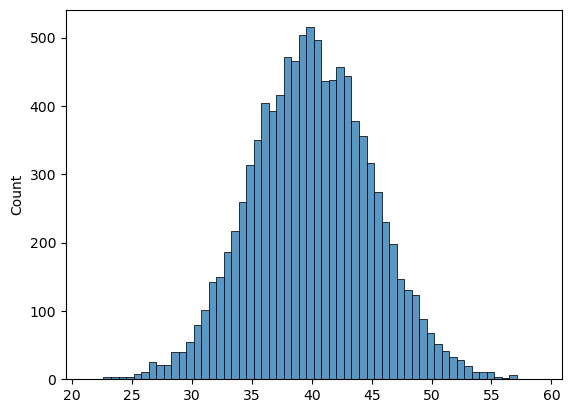

In [8]:
data_groupedby_borough = np.random.normal(40, 5, 10000)
sns.histplot(data_groupedby_borough)
plt.show


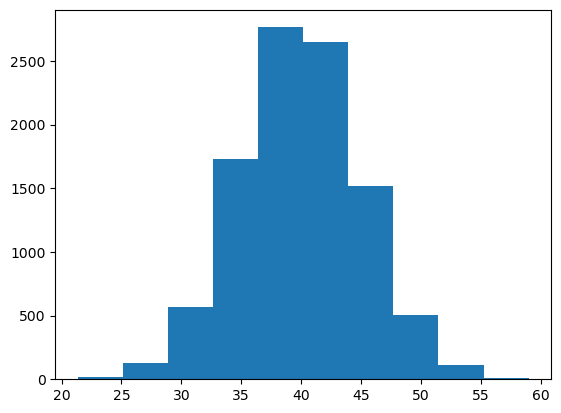

In [10]:
figure, ax = plt.subplots()
ax.hist(data_groupedby_borough) #specify bins, color, and edge color
plt.show()


In [4]:
figure, ax = plt.subplots()
ax.scatter(air_quality__df_updated['year'], air_quality__df_updated['boroughs'])
set_xlabel('Air Quality (Years)')
set_ylabel('Air Quality (Boroughs)')

plt.show()

NameError: name 'plt' is not defined

In [ ]:
sns.boxplot(data_groupedby_borough, x ='bo')

, 